# Facebook Ads CrawlerBot
---


**The following notebook contains the Python script that simulates user-agent browsing behaviour in the Facebook news feed. This script is based on the Selenium web-drivers family and aims to scrape and collect ads in screenshots and raw HTML Ad source code. This is aimed to scale up data collection and conduct investigations in ads practices.**  

<img src="assets/fbcrawler.png" alt="drawing" width="600"/>

![](assets/fb1.png)

### General requirements
The user must have access to Facebook accounts that represent a consumer trait. Therefore some activity on it to gather relevant information and attract advertisements.
Activity means:
1. Friends
2. Likes
3. Some activity on search engines. FB also captures data (from cookies) that the user types in other tabs.
4. Groups
5. Followings/Followers

If the user has a dedicated persona-trained account, more information can be captured.
The notebook is completely automated to run in the background depending on the parameters. For example, you may change the number of scrolls.

### Technical requirement
The user needs to be familiar with Python and selenium framework in order to run this notebook. Also, some HTML, JavaScript and XML knowledge is required.

### How to run this file?
You can run this notebook on Google Colab or on your local machine (Jupyter Notebook). It doesn't require any special configuration or system configuration. But if you're running it on Google Colab, make sure to follow these instructions:

https://stackoverflow.com/questions/51046454/how-can-we-use-selenium-webdriver-in-colab-research-google-com

In [1]:
# Import selenium webdriver
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
import time, os, wget

# To parse URLs from anchor tags
from urllib.parse import unquote

import pandas as pd

# To clean and beautify output obtained 
from lxml import html
from bs4 import BeautifulSoup
import os.path

## Initialise chrome driver
If you don't have one, you can download it easily from https://chromedriver.chromium.org/downloads according to the version of your Chromer browser

In [2]:
chrome_options = webdriver.ChromeOptions()
prefs = {"profile.default_content_setting_values.notifications" : 2}
chrome_options.add_experimental_option("prefs", prefs)

In [ ]:
# Specify the path to chromedriver.exe
driver = webdriver.Chrome('C:/Users/Pranav Bapat/chromedriver.exe', chrome_options=chrome_options)

# Open the webpage
driver.get("https://www.facebook.com")

In [ ]:
# Target login area. You can get this by going throught page source
username = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "input[name='email']")))
password = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "input[name='pass']")))

# Enter your FB username and password
username.clear()
username.send_keys("your_email_here")
password.clear()
password.send_keys("your_password_here")

# Target the login button and click it
button = WebDriverWait(driver, 2).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "button[type='submit']"))).click()

After executing the above script the user shall be logged in
#### Note: If you have TFA enabled on your FB account, you'll have to manually allow the request to login

Content can be:
1.	Personal post
2.	Shared post
3.	Friend suggestions (People you may know)
4.	Sponsored ads
5.	"Suggestion/Suggested for you" posts from FB
6.	"Events you may like" posts from FB
7.	Feelings posts (feeling exhausted, feeling happy)
8.	"Suggested page to follow" posts from FB
9.	Posts from groups
10.	Posts about someone commenting on someone's photo/posts/video
11.	Someone shared a memory
12.	Someone is with someone
13.	Posts from pages
14.	And so on

Such varied criteria could be problematic when targeting for ads only, as ads can be found in links, comments, or as a post itself either from pages or people.
Moreover, each content has a different DIV structure 

On FB, everything gets loaded inside DIV tags. There is the main DIV tag with the role attribute "feed". Inside this div, content have their individual DIV tags, namely "FeedUnit_0", "FeedUnit_1", "FeedUnit_n" and so on.
Inside each FeedUnit, there are fixed classes given to each element. Element refers to anything that is text or clickable. We're interested in heading, user, link of the user, link of the post, and image/video if present. Here, the user refers to either an actual user or a page or an ad.

There are two ways to get the content
#### 1.	You can get individual links, images, and headings from each DIV tag according to its classes.

Advantages:

I.	It's fast.

II.	No need to process further when all the information is obtained.

Disadvantages: 

I.	There is no fixed way for FB to show you content. Thus, you have to keep the combination of the templates for all the possible content combinations, which becomes hectic, and a slight change in any of the class names become cumbersome to manage.

II.	There is no control to filter the content. You have to sort it out manually.

#### 2.	You can get the entire main DIV structure and extract links, images, and headings using XML/JSON technology.

Advantages:

I.	The DIV structure is much cleaner.

II.	It's swift.

Disadvantages:

I.	An additional step (data cleaning and formatting) is involved in getting the content.


#### Facebook home page (after logging in), by default, has advertisements on the right side of the page.
#### Observation: They randomly change as you keep scrolling, but sometimes, they don't change at all.

In [ ]:
# Target right side panel for the links
#anchors = driver.find_elements_by_tag_name('div.cxgpxx05 div span div div a')
#anchors = [a.get_attribute('href') for a in anchors]

## Way 1

In [ ]:
# Wait 5 seconds to allow your new page to load
time.sleep(5)

driver.get("https://www.facebook.com/")

scroll = 10
for j in range(0, scroll):
    # Scroll one time entire height of the screen
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    # Wait for 5 seconds to load everything
    time.sleep(5)
    
anchors = driver.find_elements_by_tag_name('div.pedkr2u6 div div div.l9j0dhe7 div.l9j0dhe7 div div div div.j83agx80 div.rq0escxv div.j83agx80 div.l9j0dhe7 div div div div div.pybr56ya div.oi9244e8 span.nc684nl6 a')
# Get only href attribute of anchor tag
anchors = [a.get_attribute('href') for a in anchors]

fb_page_link = driver.find_elements_by_tag_name('div.pedkr2u6 div.buofh1pr h4 a')
fb_page_link = [pl.get_attribute('href') for pl in fb_page_link]

content_class = driver.find_elements_by_tag_name('div.pedkr2u6 div.buofh1pr span a')
content_class = [cc.text for cc in content_class]

headings = driver.find_elements_by_tag_name('div.pedkr2u6 div.buofh1pr h4 a strong span')
headings = [h.text for h in headings]

# All the links are preceded with an FB URL. We get rid of it by
anchors = [a for a in anchors if str(a).startswith("https://l.facebook.com/l.php?u=")]

print('Found ' + str(len(anchors)))

In [ ]:
links = []
word = 'utm'
# UTM paramter is used in almost all of the ads for companies to make revenue and detect the source of the hit. Thus, targeting
# UTM paramter is useful.

for i in anchors:
    x = i[31:]
    x = unquote(x)
    if (word.find(x) == -1):
        links.append(x)

df = pd.DataFrame(list(links))
df

# We get following output of the links

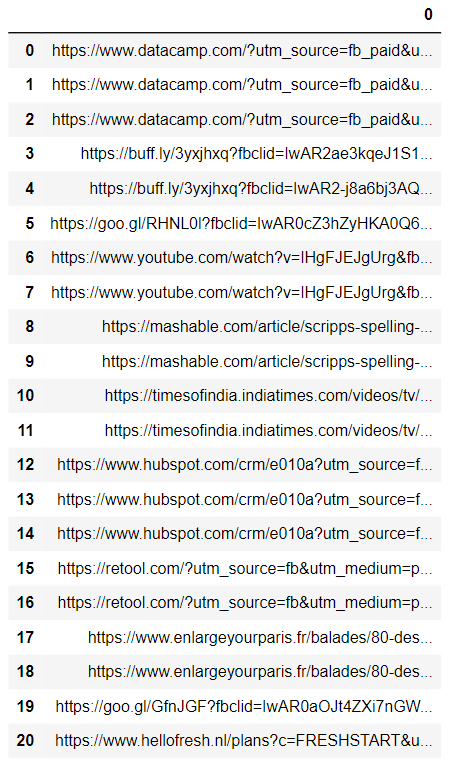

In [ ]:
headings

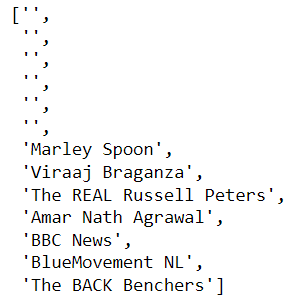

And the same way, we get content_class and fb_page_link. But as mentioned earlier, if the content jumbled up, and it will certainly be, distinguishing between the heading and links and classes becomes almost impossible. Thus, "Way 2" Is preferred.

## Way 2

In [ ]:
# Wait 5 seconds to allow your new page to load
time.sleep(5)

driver.get("https://www.facebook.com/")

scroll = 10
for j in range(0, scroll):
    # Take the screenshot, just in case, if there is an ad
    driver.save_screenshot("screenshot"+str(j)+".png")
    # Scroll one time entire height of the screen
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    # Wait for 5 seconds to load everything
    time.sleep(5)


# Get all the contents of the main DIV tag. The main DIV tag has following classes
fb_code = driver.find_element_by_xpath("//div[@class='pedkr2u6 tn0ko95a pnx7fd3z']")
fb_code = fb_code.get_attribute('innerHTML')

# Save the contents to an HTML file for further processing
html_file = 'fb_code1.html';
check_file_exists = os.path.isfile(html_file)
if(check_file_exists):
    with open(html_file, "r+", encoding="utf-8") as f:
        data = f.read()
        f.seek(0)
        f.write(fb_code)
        f.truncate()
        f.close()
else:
    f = open("fb_code1.html", "x", encoding="utf-8")
    f.write(fb_code)
    f.close()


# Correct the encoding and beautify the HTML file
contents = ''
with open(html_file, 'r', encoding="utf-8") as f:
    contents = f.read()
    f.close()
    
contents = BeautifulSoup(contents, 'lxml')

with open(html_file, "r+", encoding="utf-8") as f:
    data = f.read()
    f.seek(0)
    f.write(contents.prettify())
    f.truncate()
    f.close()

Once the files is saved, convert it to XML format using any online XML converter. And you'll get following structure:

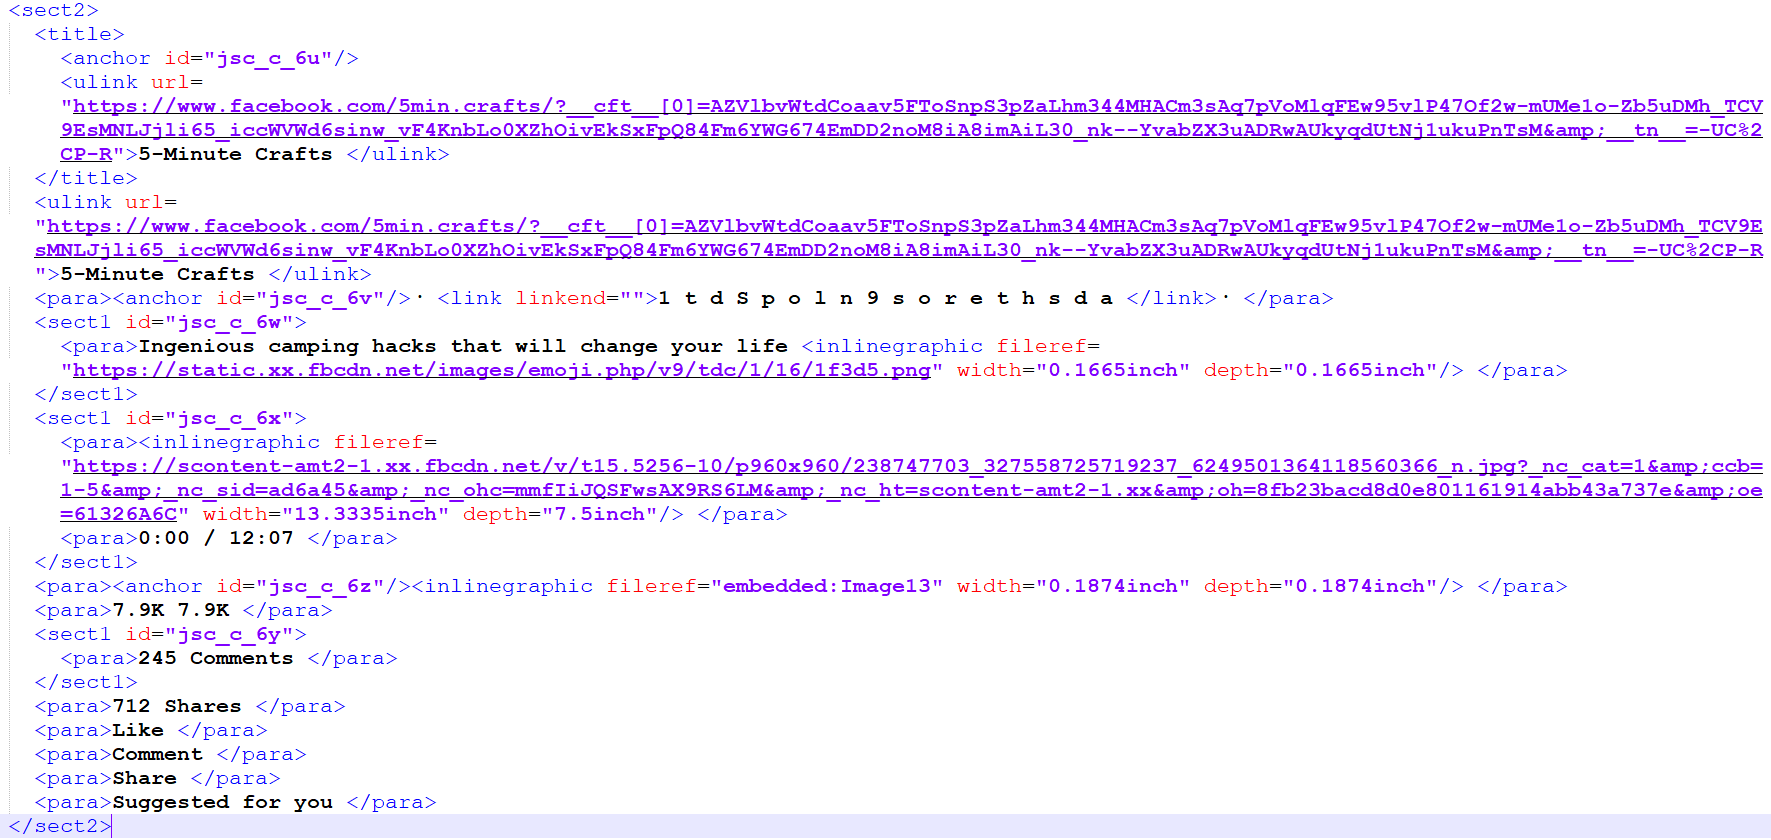

As you could see in the above image, each DIV content is within <//sect2> tag with a unique anchor tag id.

The last <//para> tag contains "Suggested for you" text, indicating that the next DIV tag is either an ad or a FB suggestion for the user. That way, we can filter which block contains ad.

Thus, instead of segregating the entire content, we just look for the DIV tags with the possibility of an ad, and neglect all the other information.